# Analyse des dommages et des tirs en Isère
Auteur : Daniel Thonon

In [37]:
import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import seaborn.objects as so


# Apply the default theme
sns.set_theme()

In [33]:
data_url = "https://raw.githubusercontent.com/dthonon/pna_loup_suivi/main/data/"
# data_url = "../data/"
# Lecture des départements
constats = pd.read_csv(
    data_url + "bilan_constat_loup_38.csv",
    sep=";",
    header=0,
    names=[
        "Commune",
        "Cercle",
        "Secteur",
        "Lieu-dit",
        "Date attaque",
        "Num semaine",
        "Animaux concernés",
        "Victimes constatées",
        "Taille troupeau ou lot",
        "Conclusion expertise",
        "Indemnisation",
        "Protocole",
        "Num AP tir",
    ],
    usecols=[
        "Commune",
        "Cercle",
        "Secteur",
        "Lieu-dit",
        "Date attaque",
        "Animaux concernés",
        "Victimes constatées",
        "Taille troupeau ou lot",
        "Conclusion expertise",
        "Indemnisation",
    ],
    parse_dates=["Date attaque"],
    dayfirst=True,
)
constats["Année"] = pd.to_datetime(constats["Date attaque"]).dt.year
constats_o = constats.query("Indemnisation == 'Oui'")
constats

,Commune,Cercle,Secteur,Lieu-dit,Date attaque,Animaux concernés,Victimes constatées,Taille troupeau ou lot,Conclusion expertise,Indemnisation,Année
0,VATILIEU,2,Bas Grésivaudan,Charbonnière,2017-04-14,Ovin,8,40.0,Loup,Oui,2017
1,VATILIEU,2,Bas Grésivaudan,Charbonnière,2017-04-16,Ovin,7,40.0,Loup,Oui,2017
2,VATILIEU,2,Bas Grésivaudan,Charbonnière,2017-04-17,Ovin,2,40.0,Loup,Oui,2017
3,VATILIEU,2,Bas Grésivaudan,Charbonnière,2017-05-04,Ovin,3,40.0,Loup,Oui,2017
4,VATILIEU,1,Bas Grésivaudan,Charbonnière,2017-05-17,Ovin,1,5.0,Loup,Oui,2017
...,...,...,...,...,...,...,...,...,...,...,...
2409,RENCUREL,1,Vercors Nord,Col de Romeyère,2023-09-27,Veau,2,NaN,Indéterminé,Non indemnisable,2023
2410,MONTAUD,1,Vercors Nord,NaN,2023-09-27,Ovin,1,NaN,Loup non exclu,Oui,2023
2411,COUBLEVIE,1,Voironnais,NaN,2023-07-10,Bovin,1,10.0,Indéterminé,Non - loup exclu,2023
2412,CHIRENS,3,Voironnais,La Louvatière,2023-09-05,Veau naissant,1,11.0,Indéterminé,Non indemnisable,2023


## Evolution des statuts d'indemnisation

In [32]:
pd.pivot_table(
    constats,
    values="Victimes constatées",
    index="Conclusion expertise",
    columns="Année",
    aggfunc="sum",
    fill_value=0,
    margins=True,
    margins_name="Total",
)

Année,2017,2018,2019,2020,2021,2022,2023,Total
Conclusion expertise,,,,,,,,
Aucun,1,7,0,0,0,0,0,8
Canidé,0,15,0,0,0,0,0,15
Charognard,6,9,4,0,1,0,8,28
Chien,5,5,1,0,0,3,0,14
Consommation post mortem,1,0,0,0,0,0,0,1
Grand canidé,1,0,0,0,0,0,0,1
Indéterminé,7,50,86,67,273,262,210,955
Instruction,1,0,0,0,0,0,0,1
Loup,690,660,0,0,0,0,0,1350


In [35]:
pd.pivot_table(
    constats_o,
    values="Victimes constatées",
    index="Conclusion expertise",
    columns="Année",
    aggfunc="sum",
    fill_value=0,
    margins=True,
    margins_name="Total",
)

Année,2017,2018,2019,2020,2021,2022,2023,Total
Conclusion expertise,,,,,,,,
Aucun,0,7,0,0,0,0,0,7
Canidé,0,13,0,0,0,0,0,13
Indéterminé,2,21,0,43,230,213,146,655
Loup,637,659,0,0,0,0,0,1296
Loup non exclu,0,0,128,183,576,602,124,1613
Loup typé,0,0,926,964,157,190,690,2927
Lynx,0,0,1,0,0,0,0,1
Total,639,700,1055,1190,963,1005,960,6512


In [34]:
pd.pivot_table(
    constats,
    values="Victimes constatées",
    index="Indemnisation",
    columns="Année",
    aggfunc="sum",
    fill_value=0,
    margins=True,
    margins_name="Total",
)

Année,2017,2018,2019,2020,2021,2022,2023,Total
Indemnisation,,,,,,,,
Attente transmission constat,0,0,0,0,3,4,0,7
En cours d'instruction,53,0,72,1,0,0,0,126
Non - loup exclu,17,23,34,16,18,12,27,147
Non indemnisable,6,31,7,56,49,85,78,312
Oui,639,700,1055,1190,963,1005,960,6512
Total,715,754,1168,1263,1033,1106,1065,7104


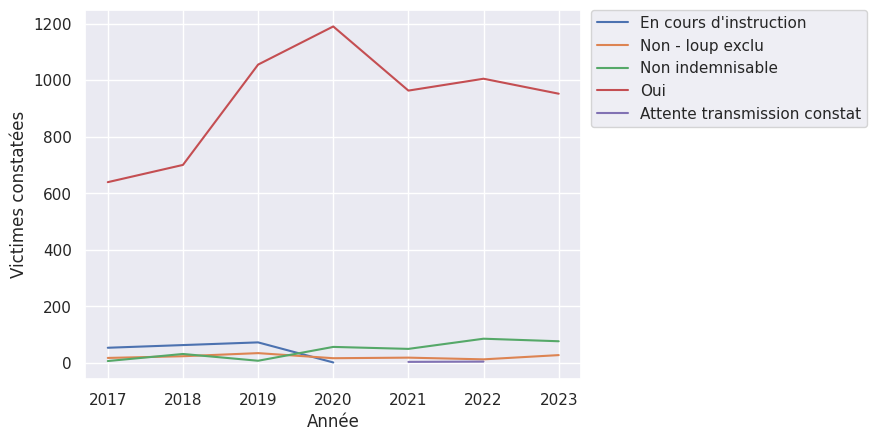

In [5]:
par_indemnisation_l = constats.groupby(["Année", "Indemnisation"]).sum(
    numeric_only=True
)
sns.lineplot(
    data=par_indemnisation_l, x="Année", y="Victimes constatées", hue="Indemnisation"
)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

Année,2023
Indemnisation,
Attente transmission constat,0
En cours d'instruction,0
Non - loup exclu,27
Non indemnisable,76
Oui,952


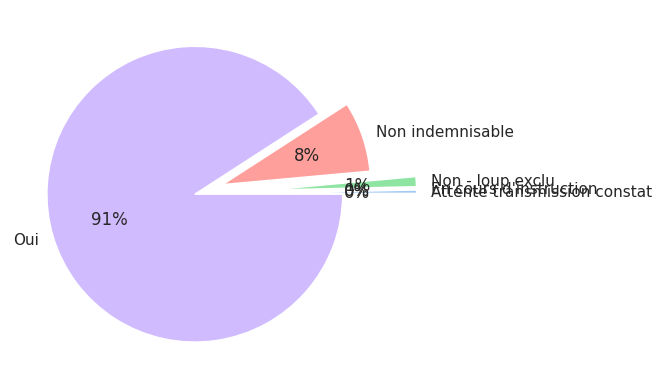

In [22]:
par_indemnisation = pd.pivot_table(
    constats,
    values="Victimes constatées",
    index="Indemnisation",
    columns="Année",
    aggfunc="sum",
    fill_value=0,
)
data = list(par_indemnisation[[2022]].values.flat)
labels = par_indemnisation[[2022]].index.values
colors = sns.color_palette("pastel")[0:7]
explode = (0.5, 0.5, 0.5, 0.2, 0)
plt.pie(
    data,
    labels=labels,
    colors=colors,
    explode=explode,
    autopct="%1.0f%%",
    labeldistance=1.1,
)
par_indemnisation[[2023]]

## Evolution par type d'animal de rente prédaté

In [23]:
par_animal = pd.pivot_table(
    constats_o,
    values="Victimes constatées",
    index="Animaux concernés",
    columns="Année",
    aggfunc="sum",
    fill_value=0,
    # margins=True,
    # margins_name="Total"
)
par_animal

Année,2017,2018,2019,2020,2021,2022,2023
Animaux concernés,,,,,,,
Anon naissant,1,0,0,0,0,0,0
Autre,0,0,0,3,0,2,1
Bovin,4,17,17,28,13,26,50
Canin,0,1,0,4,2,3,8
Caprin,4,4,14,33,46,40,14
Equin,0,2,3,0,1,2,1
Ovin,622,667,1001,1107,854,888,842
Veau,4,0,11,8,33,29,18
Veau naissant,4,9,9,7,14,15,17


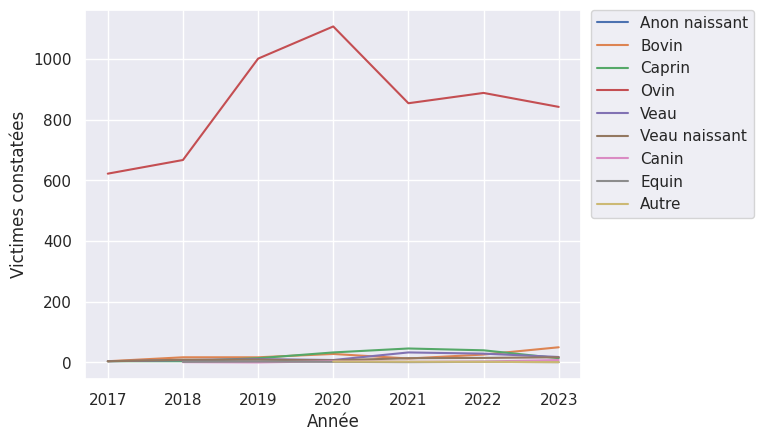

In [9]:
par_animal_l = constats_o.groupby(["Année", "Animaux concernés"]).sum(numeric_only=True)
sns.lineplot(
    data=par_animal_l, x="Année", y="Victimes constatées", hue="Animaux concernés"
)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

## Evolution par secteur

Le tableau suivant résume les dommages indemnisés par secteur.

In [ ]:
sorted(constats.Secteur.unique())

In [26]:
par_secteur = pd.pivot_table(
    constats,
    values="Victimes constatées",
    index="Secteur",
    columns="Année",
    aggfunc="sum",
    fill_value=0,
    margins=True,
    margins_name="Total",
)
par_secteur

Année,2017,2018,2019,2020,2021,2022,2023,Total
Secteur,,,,,,,,
Balmes Viennoises,0,0,0,0,0,0,3,3
Bas Drac,9,0,0,9,0,2,1,21
Bas Grésivaudan,21,1,5,43,3,17,3,93
Beaumont,5,16,18,35,3,29,40,146
Belledonne Centre,53,22,38,51,46,45,26,281
Belledonne Nord,20,41,18,20,15,23,20,157
Belledonne Sud,32,17,25,18,39,99,58,288
Bièvre,1,0,1,4,8,9,7,30
Chambarans,0,5,0,0,4,57,39,105


In [27]:
par_secteur = pd.pivot_table(
    constats_o,
    values="Victimes constatées",
    index="Secteur",
    columns="Année",
    aggfunc="sum",
    fill_value=0,
    margins=True,
    margins_name="Total",
)
par_secteur

Année,2017,2018,2019,2020,2021,2022,2023,Total
Secteur,,,,,,,,
Balmes Viennoises,0,0,0,0,0,0,2,2
Bas Drac,9,0,0,5,0,1,1,16
Bas Grésivaudan,21,1,5,37,2,3,1,70
Beaumont,0,14,18,35,3,27,35,132
Belledonne Centre,49,18,34,43,45,42,26,257
Belledonne Nord,18,41,18,15,14,23,19,148
Belledonne Sud,28,15,22,18,36,86,49,254
Bièvre,0,0,0,1,8,9,4,22
Chambarans,0,2,0,0,3,49,22,76


In [28]:
par_secteur = pd.pivot_table(
    constats,
    values="Victimes constatées",
    index="Secteur",
    columns="Année",
    aggfunc="count",
    fill_value=0,
    margins=True,
    margins_name="Total",
)
par_secteur

Année,2017,2018,2019,2020,2021,2022,2023,Total
Secteur,,,,,,,,
Balmes Viennoises,0,0,0,0,0,0,3,3
Bas Drac,1,0,0,6,0,2,1,10
Bas Grésivaudan,5,1,3,9,3,5,3,29
Beaumont,3,8,11,8,2,11,22,65
Belledonne Centre,19,16,21,25,26,20,15,142
Belledonne Nord,5,10,9,10,11,9,9,63
Belledonne Sud,11,15,13,14,23,39,32,147
Bièvre,1,0,1,4,7,5,7,25
Chambarans,0,4,0,0,4,28,24,60


In [29]:
par_secteur = pd.pivot_table(
    constats_o,
    values="Victimes constatées",
    index="Secteur",
    columns="Année",
    aggfunc="count",
    fill_value=0,
    margins=True,
    margins_name="Total",
)
par_secteur

Année,2017,2018,2019,2020,2021,2022,2023,Total
Secteur,,,,,,,,
Balmes Viennoises,0,0,0,0,0,0,2,2
Bas Drac,1,0,0,3,0,1,1,6
Bas Grésivaudan,5,1,3,6,2,1,1,19
Beaumont,0,6,11,8,2,9,21,57
Belledonne Centre,18,11,18,20,25,18,15,125
Belledonne Nord,3,10,9,7,10,9,8,56
Belledonne Sud,7,13,10,14,20,32,26,122
Bièvre,0,0,0,1,7,5,4,17
Chambarans,0,1,0,0,3,22,14,40


## Evolution par commune

In [31]:
par_commune = pd.pivot_table(
    constats_o,
    values="Victimes constatées",
    index="Commune",
    columns="Année",
    aggfunc="sum",
    fill_value=0,
    margins=True,
    margins_name="Total",
)
pd.set_option("display.max_rows", 500)
par_commune

Année,2017,2018,2019,2020,2021,2022,2023,Total
Commune,,,,,,,,
ALLEMOND,20,2,1,12,5,4,0,44
ALLEVARD,17,21,6,1,1,0,0,46
AURIS,9,0,3,49,4,5,18,88
AUTRANS-MÉAUDRE EN VERCORS,2,0,0,0,3,0,0,5
AVIGNONET,6,0,0,0,0,0,0,6
BESSE,26,2,22,13,31,19,19,132
BESSINS,0,0,0,0,0,4,0,4
BIOL,0,0,0,0,3,0,0,3
BOSSIEU,0,0,0,0,8,10,1,19


## Pression de prédation

In [59]:
# gis_dir = "/home/daniel/Data/SIG/ADMIN-EXPRESS/1_DONNEES_LIVRAISON_2021-11-16/ADE_3-1_SHP_LAMB93_FR/"
gis_url = "https://data.geopf.fr/wfs"
gis_layer = "ADMINEXPRESS-COG.LATEST:commune"
params = dict(
    service="WFS",
    version="2.0.0",
    request="GetFeature",
    typeName=gis_layer,
    outputFormat="json",
    cql_filter="insee_dep=38",
)
r = requests.Request("GET", gis_url, params=params).prepare()

communes = gpd.read_file(r.url)
# departements = gpd.read_file(gis_dir + "DEPARTEMENT.shp")
# communes = gpd.read_file(gis_dir + "COMMUNE.shp")

In [68]:
communes_38 = (
    communes[["nom_m", "geometry"]]
    .rename(columns={"nom_m": "Commune"})
    .set_index("Commune")
)
communes_38

,geometry
Commune,
LE BOURG-D'OISANS,"MULTIPOLYGON (((5.97563 45.09851, 5.97599 45.1..."
SARDIEU,"MULTIPOLYGON (((5.19753 45.35665, 5.19614 45.3..."
VIF,"MULTIPOLYGON (((5.71338 45.07230, 5.71325 45.0..."
SAINT-LAURENT-DU-PONT,"MULTIPOLYGON (((5.72951 45.41824, 5.72975 45.4..."
SAINT-THEOFFREY,"MULTIPOLYGON (((5.77545 45.01712, 5.77555 45.0..."
...,...
REVEL-TOURDAN,"MULTIPOLYGON (((5.00797 45.36407, 5.00780 45.3..."
BEAUCROISSANT,"MULTIPOLYGON (((5.44458 45.36734, 5.44587 45.3..."
MAUBEC,"MULTIPOLYGON (((5.26863 45.55293, 5.26857 45.5..."


In [69]:
par_commune_l = constats_o.groupby(["Année", "Commune"]).sum(numeric_only=True)

par_commune_l_2017 = (
    par_commune_l.query("Année == 2017")
    .reset_index(inplace=False)
    .set_index("Commune")
    .drop(columns="Année")
)
par_commune_l_2017 = communes_38.merge(
    par_commune_l_2017, left_index=True, right_index=True, how="outer"
)
par_commune_l_2018 = (
    par_commune_l.query("Année == 2018")
    .reset_index(inplace=False)
    .set_index("Commune")
    .drop(columns="Année")
)
par_commune_l_2018 = communes_38.merge(
    par_commune_l_2018, left_index=True, right_index=True, how="outer"
)
par_commune_l_2019 = (
    par_commune_l.query("Année == 2019")
    .reset_index(inplace=False)
    .set_index("Commune")
    .drop(columns="Année")
)
par_commune_l_2019 = communes_38.merge(
    par_commune_l_2019, left_index=True, right_index=True, how="outer"
)
par_commune_l_2020 = (
    par_commune_l.query("Année == 2020")
    .reset_index(inplace=False)
    .set_index("Commune")
    .drop(columns="Année")
)
par_commune_l_2020 = communes_38.merge(
    par_commune_l_2020, left_index=True, right_index=True, how="outer"
)
par_commune_l_2021 = (
    par_commune_l.query("Année == 2021")
    .reset_index(inplace=False)
    .set_index("Commune")
    .drop(columns="Année")
)
par_commune_l_2021 = communes_38.merge(
    par_commune_l_2021, left_index=True, right_index=True, how="outer"
)
par_commune_l_2022 = (
    par_commune_l.query("Année == 2022")
    .reset_index(inplace=False)
    .set_index("Commune")
    .drop(columns="Année")
)
par_commune_l_2022 = communes_38.merge(
    par_commune_l_2022, left_index=True, right_index=True, how="outer"
)
par_commune_l_2023 = (
    par_commune_l.query("Année == 2023")
    .reset_index(inplace=False)
    .set_index("Commune")
    .drop(columns="Année")
)
par_commune_l_2023 = communes_38.merge(
    par_commune_l_2023, left_index=True, right_index=True, how="outer"
)

In [70]:
par_commune_l_2023

,geometry,Victimes constatées,Taille troupeau ou lot
Commune,,,
AGNIN,"MULTIPOLYGON (((4.84455 45.33812, 4.84455 45.3...",NaN,NaN
ALLEMOND,"MULTIPOLYGON (((5.97847 45.12017, 5.97840 45.1...",NaN,NaN
ALLEVARD,"MULTIPOLYGON (((6.17001 45.35954, 6.17042 45.3...",NaN,NaN
AMBEL,"MULTIPOLYGON (((5.92044 44.81313, 5.92070 44.8...",NaN,NaN
ANJOU,"MULTIPOLYGON (((4.88746 45.36806, 4.88787 45.3...",NaN,NaN
...,...,...,...
VIZILLE,"MULTIPOLYGON (((5.78847 45.04909, 5.78789 45.0...",NaN,NaN
VOIRON,"MULTIPOLYGON (((5.56805 45.34738, 5.56807 45.3...",NaN,NaN
VOISSANT,"MULTIPOLYGON (((5.71982 45.48316, 5.71968 45.4...",NaN,NaN


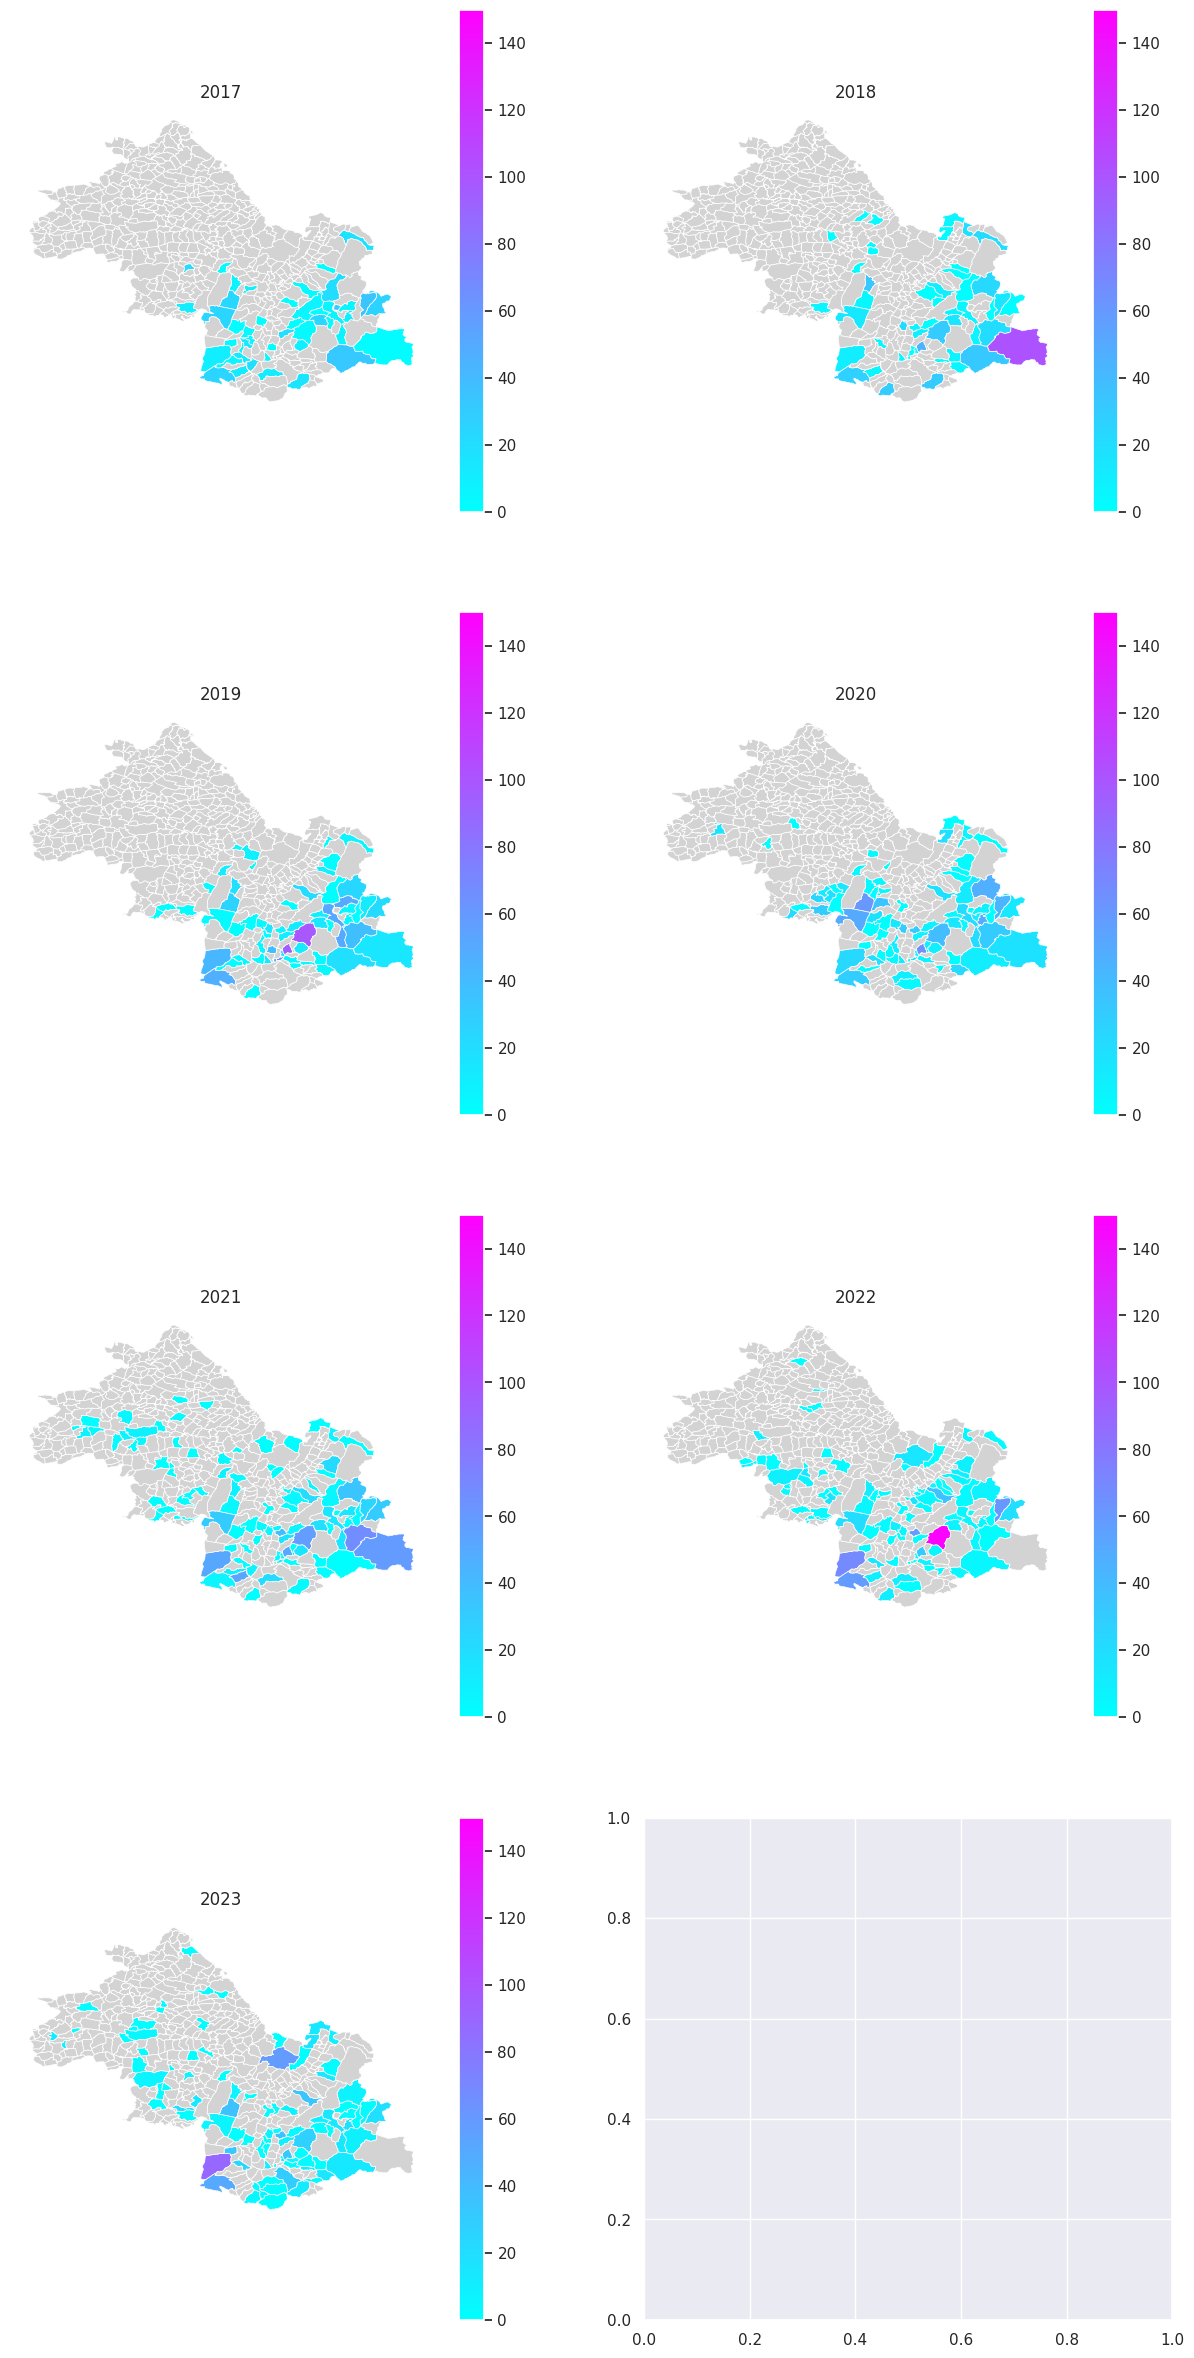

In [73]:
fig, axs = plt.subplots(4, 2, figsize=(15, 30))
axs[0, 0].set_axis_off()
axs[0, 0].set_title("2017")
par_commune_l_2017.plot(
    ax=axs[0, 0],
    column="Victimes constatées",
    linewidth=0.5,
    legend=True,
    # legend_kwds={"label": "Prédations par commune", "orientation": "horizontal"},
    missing_kwds={"color": "lightgrey"},
    cmap="cool",
    vmin=0,
    vmax=150,
)
axs[0, 1].set_axis_off()
axs[0, 1].set_title("2018")
par_commune_l_2018.plot(
    ax=axs[0, 1],
    column="Victimes constatées",
    linewidth=0.5,
    legend=True,
    # legend_kwds={"label": "Prédations par commune", "orientation": "horizontal"},
    missing_kwds={"color": "lightgrey"},
    cmap="cool",
    vmin=0,
    vmax=150,
)
axs[1, 0].set_axis_off()
axs[1, 0].set_title("2019")
par_commune_l_2019.plot(
    ax=axs[1, 0],
    column="Victimes constatées",
    linewidth=0.5,
    legend=True,
    # legend_kwds={"label": "Prédations par commune", "orientation": "horizontal"},
    missing_kwds={"color": "lightgrey"},
    cmap="cool",
    vmin=0,
    vmax=150,
)
axs[1, 1].set_axis_off()
axs[1, 1].set_title("2020")
par_commune_l_2020.plot(
    ax=axs[1, 1],
    column="Victimes constatées",
    linewidth=0.5,
    legend=True,
    # legend_kwds={"label": "Prédations par commune", "orientation": "horizontal"},
    missing_kwds={"color": "lightgrey"},
    cmap="cool",
    vmin=0,
    vmax=150,
)
axs[2, 0].set_axis_off()
axs[2, 0].set_title("2021")
par_commune_l_2021.plot(
    ax=axs[2, 0],
    column="Victimes constatées",
    linewidth=0.5,
    legend=True,
    # legend_kwds={"label": "Prédations par commune", "orientation": "horizontal"},
    missing_kwds={"color": "lightgrey"},
    cmap="cool",
    vmin=0,
    vmax=150,
)
axs[2, 1].set_axis_off()
axs[2, 1].set_title("2022")
par_commune_l_2022.plot(
    ax=axs[2, 1],
    column="Victimes constatées",
    linewidth=0.5,
    legend=True,
    # legend_kwds={"label": "Prédations par commune", "orientation": "horizontal"},
    missing_kwds={"color": "lightgrey"},
    cmap="cool",
    vmin=0,
    vmax=150,
)
axs[3, 0].set_axis_off()
axs[3, 0].set_title("2023")
par_commune_l_2023.plot(
    ax=axs[3, 0],
    column="Victimes constatées",
    linewidth=0.5,
    legend=True,
    # legend_kwds={"label": "Prédations par commune", "orientation": "horizontal"},
    missing_kwds={"color": "lightgrey"},
    cmap="cool",
    vmin=0,
    vmax=150,
)

## Etude de certains secteurs

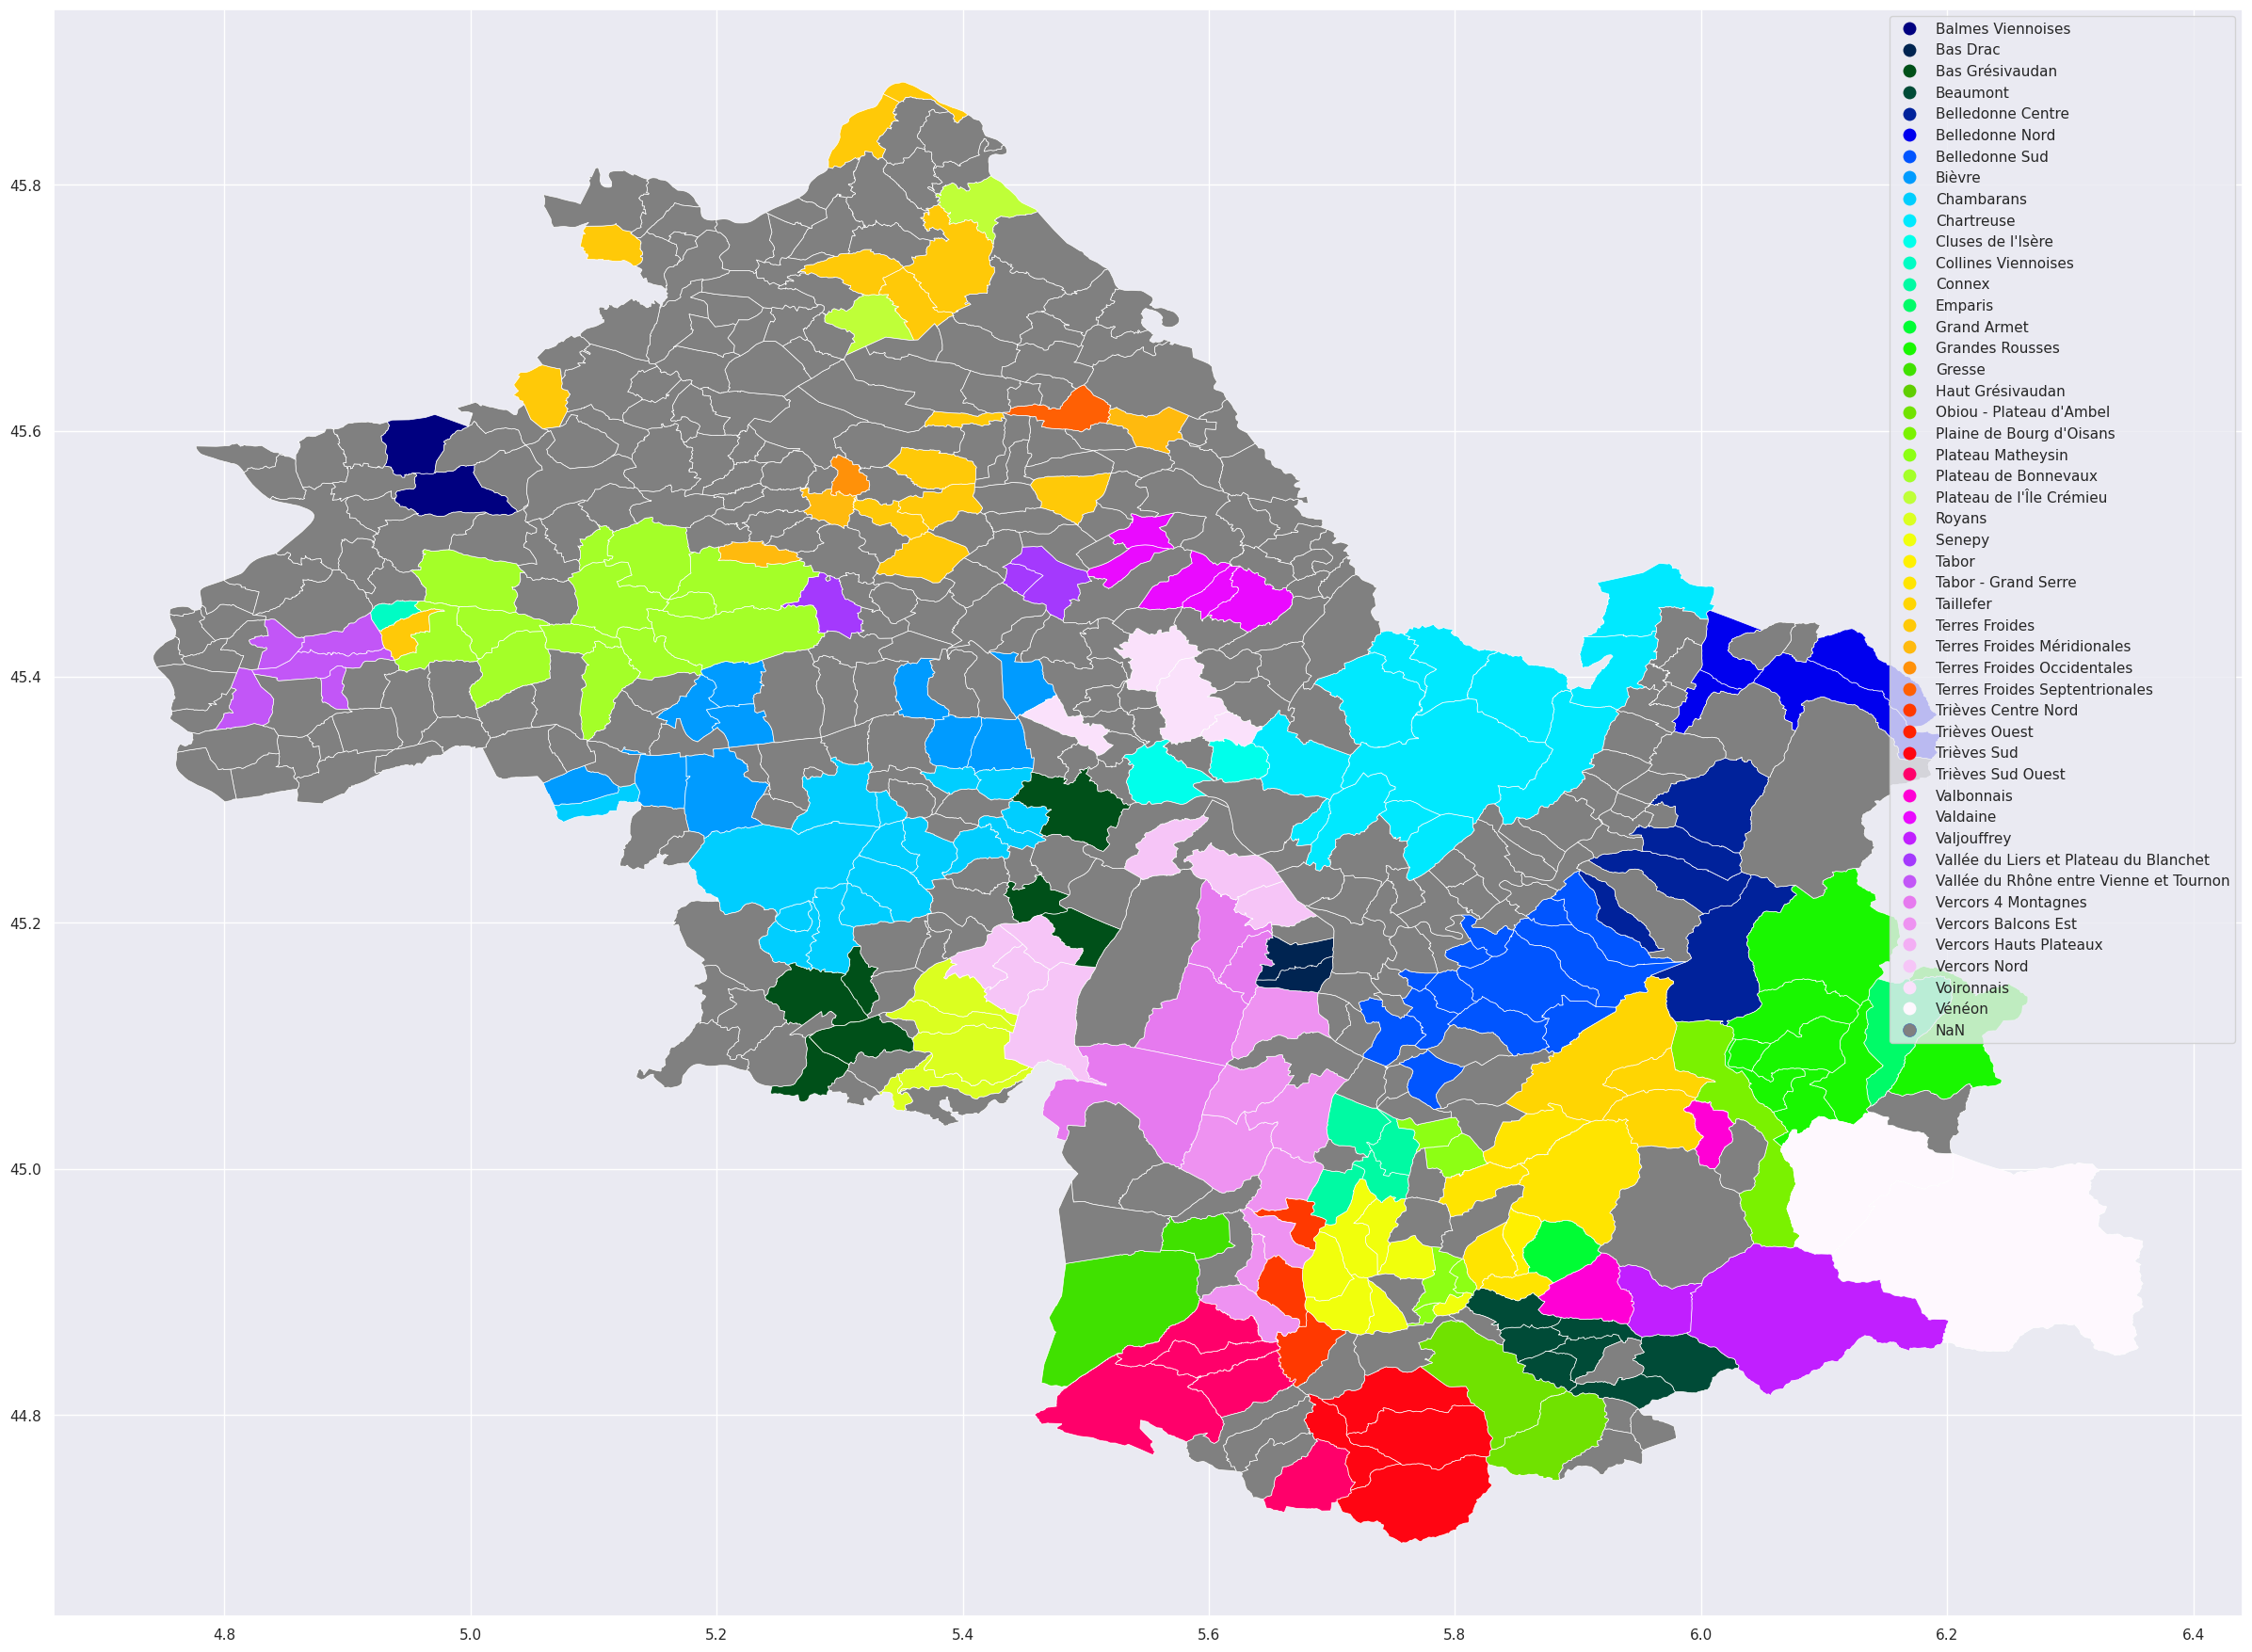

In [100]:
secteurs = communes_38.merge(
    constats[["Commune", "Secteur"]].drop_duplicates(), on="Commune", how="outer"
)
secteurs.plot(
    column="Secteur",
    categorical=True,
    missing_kwds={"color": "grey"},
    legend=True,
    figsize=(30,30),
    cmap="gist_ncar",
    linewidth=0.5,
);

### Belledonne Sud

In [17]:
constats_bs = constats_o.query("Secteur == 'Belledonne Sud' & Année > 2015")
# constats_bs.sort_values(by="Date attaque")

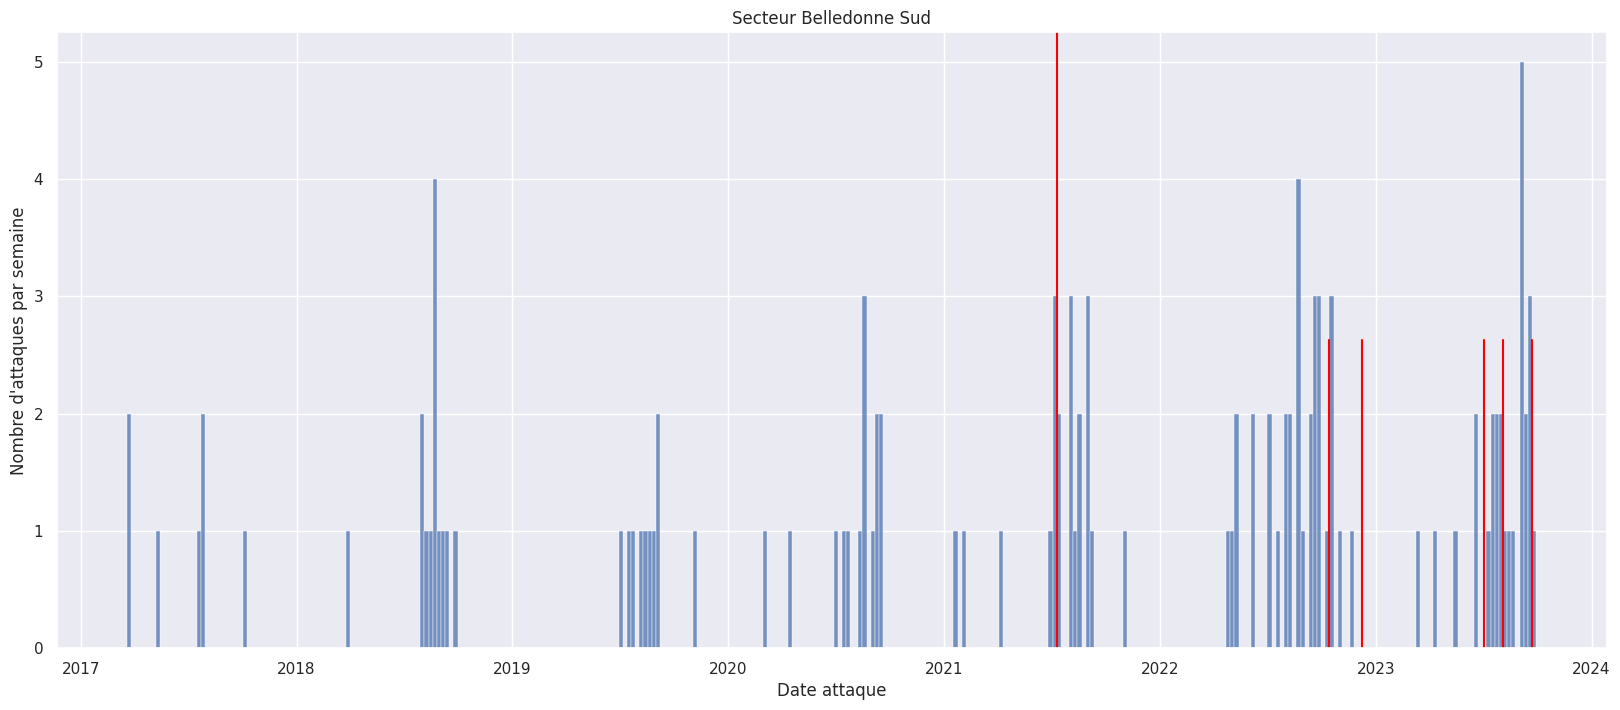

In [74]:
plt.figure(figsize=(20, 8))
# ax = sns.scatterplot(data=constats_bs, x="Date attaque", y="Victimes constatées").set(title="Secteur Belledonne Sud");
ax = sns.histplot(data=constats_bs, x="Date attaque", binwidth=7).set(
    title="Secteur Belledonne Sud", ylabel="Nombre d'attaques par semaine"
)
plt.axvline(x=datetime.datetime(2021, 7, 11), color="red")
plt.axvline(x=datetime.datetime(2022, 10, 13), color="red", ymax=0.5)
plt.axvline(x=datetime.datetime(2022, 12, 8), color="red", ymax=0.5)
plt.axvline(x=datetime.datetime(2023, 7, 3), color="red", ymax=0.5)
plt.axvline(x=datetime.datetime(2023, 8, 4), color="red", ymax=0.5)
plt.axvline(x=datetime.datetime(2023, 9, 23), color="red", ymax=0.5)
plt.show()

### Belledonne centre

In [ ]:
constats_bc = constats_o.query("Secteur == 'Belledonne Centre' & Année > 2015")

In [ ]:
plt.figure(figsize=(20, 8))
# ax = sns.scatterplot(data=constats_bs, x="Date attaque", y="Victimes constatées").set(title="Secteur Belledonne Sud");
ax = sns.histplot(data=constats_bc, x="Date attaque", binwidth=7).set(
    title="Secteur Belledonne Centre", ylabel="Nombre d'attaques par semaine"
)
plt.show()

### Belledonne Nord

In [ ]:
constats_bn = constats_o.query("Secteur == 'Belledonne Centre' & Année > 2015")

In [ ]:
plt.figure(figsize=(20, 8))
ax = sns.histplot(data=constats_bn, x="Date attaque", binwidth=7).set(
    title="Secteur Belledonne Nord", ylabel="Nombre d'attaques par semaine"
)
plt.show()

### Beaumont

In [ ]:
constats_b = constats_o.query("Secteur == 'Beaumont' & Année > 2015")
# constats_b.sort_values(by="Date attaque")

In [ ]:
plt.figure(figsize=(20, 8))
ax = sns.histplot(data=constats_b, x="Date attaque", binwidth=7).set(
    title="Secteur Beaumont", ylabel="Nombre d'attaques par semaine"
)
plt.axvline(x=datetime.datetime(2022, 10, 7), color="red")
plt.show()